# 使用数字代替文本 

## one-hot向量

使用one-hot向量十分低效，one-hot向量十分稀疏，大部分都是0
并且随着词汇表大小的增加，one-hot向量的维度也会不断变大

## 使用单独的数字进行编码

我们对每一个单词进行编码，每一个单词对应一个数字，这样虽然十分高效，但是：
1. 使用一个数字编码一个单词过于绝对，这样不能获得到单词间的联系
2. 使用一个数字是的模型对于该单词解释过于困难。如线性分类器为每个特征学习单个权重。因为两个单词之间的相似性与其编码之间的相似性没有任何关系，这种特征权重的组合是没有意义的

## word embedding

词嵌入为我们提供了一种使用高效、密集表示的方法，其中相似的单词具有相似的编码。重要的是，我们不必手工指定这种编码。嵌入是浮点值的密集向量（向量的长度是您指定的参数）。它们不是手动指定嵌入的值，而是可训练的参数（训练期间模型学习的权重，与模型学习稠密层权重的方式相同）。在处理大型数据集时，常见的词嵌入是8维的（对于小型数据集），最多可达1024维。更高维度的嵌入可以捕获单词之间的细粒度关系，但需要更多的数据来学习。

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


对于此数据集，进行一点说明，只是我自己的想法，此文本编码器将可逆地对任何字符串进行编码，必要时返回字节编码。  
有些词汇并不在我们最终训练的词汇表中。
最终的词汇表里面有写并不是一个完整的单词。
可能是 因为词汇表只有8185.可能有些词语没有收录，就只能对该单词部分字节编码了（词汇表中包含了用于构建一些大单词的部分词根，所以可以构建任何单词。）  
比如词汇表中没有tensorflow，就会将其拆分为单词表中有的'ten'+'sor'+'fl'+'ow'这四部分词根

In [3]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

The "_" in the vocabulary represent spaces. Note how the vocabulary includes whole words (ending with "_") and partial words which it can use to build larger words:
单词后面的_代表的是空格，词汇表中还会看到一些部分单词，这代表的是用于构建一些单词的部分词根，如‘br’，‘er’等

In [4]:
encoder=info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [5]:
for i in train_data.take(5):
    print(i)

(<tf.Tensor: id=116, shape=(855,), dtype=int64, numpy=
array([ 249,    4,  277,  309,  560,    6, 6639, 4574,    2,   12,   31,
       7759, 3525, 2128,   93, 2306,   43, 2312, 2527,    6,   30, 1334,
       8044,   24,   10,   16,   10,   17,  977,   30,  815, 3339,   41,
        841, 7911,  376, 7974, 1923,    6,  607,  219,   44,  242, 1603,
         11, 4329,  102, 2821, 1139,    2,  969,  161,   51,   18,    4,
       5844, 2820,  123, 4493,   40,    6, 4571,   13,  117,   35,  289,
        850,  455,   50,  460, 6359, 1069,  343,   20,    1, 3733, 3511,
       7670,    3,  147,    4,  336,    2,   42,   18,    4, 3422,  409,
       3533,  871, 2836,  311,    5, 5080, 1209,    3,  183,  117,   35,
       1187,    5, 1955,   11,    1,  226, 7745,    3,  183, 1466, 7359,
       7961, 1466,  665,    2, 6854, 3178, 1377, 6266, 1447,  297,    2,
       5797,   36, 4740,  847, 8050,    2,    5, 1929, 1631, 5986,   22,
       5541, 5688,    5, 1036, 3746, 8050,    3,   69,  264,   35,   

In [6]:
# 使用padded_batch方法来标准化评论的长度
padded_shapes=([None],())
train_batchs=train_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)
test_batchs=test_data.shuffle(1000).padded_batch(10,padded_shapes=padded_shapes)

In [7]:
# 样本都被padding到了每一批中最长的样本长度
train_batch,train_label=next(iter(train_batchs))
train_batch.numpy(),train_batch.numpy().shape

(array([[ 597,    1, 2848, ...,    0,    0,    0],
        [ 324,   12,  118, ...,    0,    0,    0],
        [ 324,   12,   18, ...,    0,    0,    0],
        ...,
        [  62, 2676,  150, ...,    0,    0,    0],
        [  19, 2165, 1103, ...,    0,    0,    0],
        [ 693,    4,  294, ...,    0,    0,    0]]), (10, 484))

### 创建连续词袋模型 

1. 接下来，嵌入层采用整数编码的词汇表，并查找每个单词索引的嵌入向量。这些向量作为模型训练来学习。嵌入向量向输出数组添加一个维度。生成的维度是：（批处理、序列、嵌入）。 
2. 接下来，GlobalAveragePooling1D层通过在序列维度上求平均值来为每个示例返回固定长度的输出向量。这允许模型以最简单的方式处理可变长度的输入。
3. 这个固定长度的输出向量通过一个具有16个隐藏单元的完全连接（密集）层进行管道传输。
4. 最后一层与单个输出节点紧密连接。使用sigmoid激活函数，这个值是介于0和1之间的一个浮点数，表示评审为正的概率（或置信水平）。

In [8]:
embedding_dim=50
model=keras.Sequential([
    layers.Embedding(encoder.vocab_size,embedding_dim),
    layers.GlobalAveragePooling1D(),
    # 删除这一层，模型更加简单，获得的词向量更具有解释性
#     layers.Dense(16,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          409250    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 409,301
Trainable params: 409,301
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpoint_save_path = "./checkpoint/word_embedding.ckpt"

# 用于加载模型，checkpoint中保存好了已经训练好了的模型权重，加载之后可以不用训练了
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 # monitor='loss',
                                                 # save_best_only=True,
                                                 verbose=2)

-------------load the model-----------------


In [168]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
history=model.fit(train_batchs,validation_data=test_batchs,epochs=10,callbacks=[cp_callback])

Epoch 1/10
   2500/Unknown - 39s 15ms/step - loss: 0.5800 - accuracy: 0.7372
Epoch 00001: saving model to ./checkpoint/word_embedding.ckpt
2500/2500 [==============================] - 49s 20ms/step - loss: 0.5800 - accuracy: 0.7372 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
2499/2500 [============================>.] - ETA: 0s - loss: 0.3722 - accuracy: 0.8719
Epoch 00002: saving model to ./checkpoint/word_embedding.ckpt
2500/2500 [==============================] - 46s 19ms/step - loss: 0.3722 - accuracy: 0.8719 - val_loss: 0.3638 - val_accuracy: 0.8500
Epoch 3/10
2499/2500 [============================>.] - ETA: 0s - loss: 0.2944 - accuracy: 0.8990
Epoch 00003: saving model to ./checkpoint/word_embedding.ckpt
2500/2500 [==============================] - 46s 18ms/step - loss: 0.2944 - accuracy: 0.8990 - val_loss: 0.3234 - val_accuracy: 0.8774
Epoch 4/10
2498/2500 [============================>.] - ETA: 0s - loss: 0.2529 - accuracy: 0.9126
Epoch 00004: saving model to .

In [169]:
import pandas as pd
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.202403,0.93136,0.312740,0.87992,5
6,0.187597,0.93800,0.328004,0.87992,6
7,0.171211,0.94360,0.336856,0.87812,7
8,0.160657,0.94848,0.346631,0.87600,8
9,0.147951,0.95196,0.366205,0.87292,9


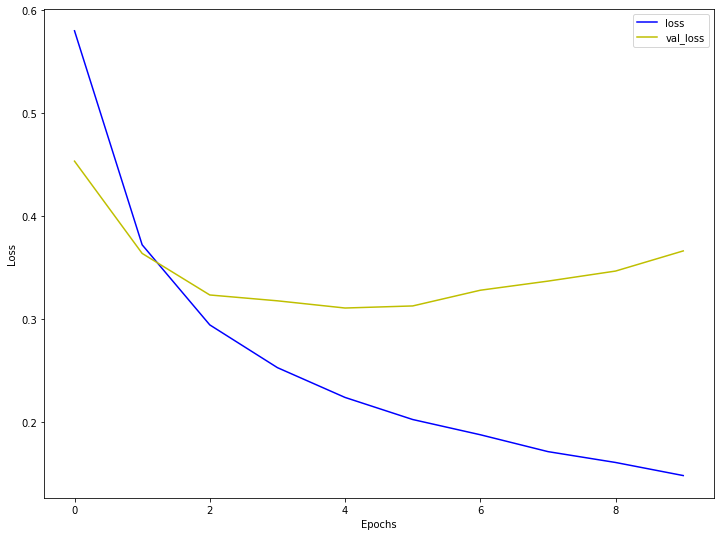

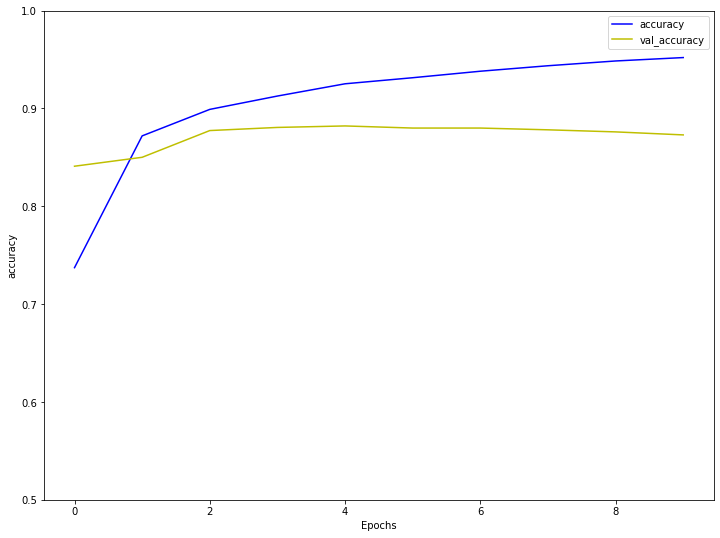

In [170]:
import matplotlib.pyplot as plt

def plot_histrory(hist):
    acc=hist['accuracy']
    val_acc=hist['val_accuracy']
    loss=hist['loss']
    val_loss=hist['val_loss']
    epochs=hist['epoch']
    
    plt.figure(figsize=(12,9))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(epochs,loss,'b',label='loss')
    plt.plot(epochs,val_loss,'y',label='val_loss')
    plt.legend()
    
    plt.figure(figsize=(12,9))
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.plot(epochs,acc,'b',label='accuracy')
    plt.plot(epochs,val_acc,'y',label='val_accuracy')
    plt.ylim((0.5,1))
    plt.legend()
    plt.show()
    
plot_histrory(hist)
    


过拟合了，应该使用early stop

## 取回训练后的词向量

In [11]:
# 词向量的维度是（vocab_size,embeddind_dim)
embedding=model.layers[0]
weights=embedding.get_weights()[0]
print(weights.shape)
# # shape: (vocab_size, embedding_dim)

(8185, 50)


In [12]:
weights

array([[-3.0715574e-02, -9.7402083e-03,  7.1080280e-03, ...,
        -4.1277677e-02, -3.2551829e-02, -1.0754213e-02],
       [-5.7949889e-02, -1.3188884e-01,  1.2960285e-01, ...,
        -6.7576453e-02,  1.4749292e-01,  6.5039568e-02],
       [-4.9706578e-02, -3.4362182e-02, -2.7974624e-02, ...,
         3.1775970e-02,  4.8390478e-02,  4.7251183e-04],
       ...,
       [-1.1999406e-02, -3.4446169e-02, -3.1842768e-02, ...,
         4.2763200e-02,  4.8610698e-02, -1.2107529e-02],
       [ 2.8718960e-02, -2.8883422e-02,  1.1111699e-02, ...,
         2.2771027e-02,  4.3267559e-02, -4.6028461e-02],
       [-4.6266865e-02,  1.7715883e-02, -3.6221743e-04, ...,
         3.5734896e-02, -5.0734729e-05,  1.4471900e-02]], dtype=float32)

In [13]:
# 将得到的词向量与对于单词保存到文本中
# 以下代码来自于官方教程，但是我认为这是错误的
# 以至于之后我找最后最接近的10个单词结果很诡异
# 词汇表中第一个单词是'the_'
# 时间上这个单词对应的编码是[181, 8024]
# 单词the对应的是 181，‘_'对应8024
# 这样也就可以解释subwords只有7928个，voabsize是8025
# 在之后找top10接近的词向量中，我会给出正确的写法
# 当然，以上只是我个人想法，也许我没有理解官方教程的意思
import io
encoder=info.features['text'].encoder
out_v=io.open('word_embedding/vecs.tsv','w',encoding='utf-8')
out_m=io.open('word_embedding/meta.tsv','w',encoding='utf-8')
for num, word in enumerate(encoder.subwords):
    vec = weights[num+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    print(num)
out_v.close()
out_m.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588


4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087


7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302


## 找最相似的10个单词

In [14]:
len(encoder.subwords),encoder.vocab_size #encoder中遍历单词个数与vocab_size不一致
# 原因是 subwords包含的是单词以及部分词根，而词汇表中包含了一些符号，如'_',','等等

(7928, 8185)

In [15]:
import numpy as np

In [16]:
# 计算两个词向量的距离
def calDistance(x1,x2):
    return np.sum(np.square(x1-x2))

In [17]:
#  构建距离矩阵
def build_distance_matrix(vec):
    # 距离矩阵
    D=[[0 for _ in range(len(vec))] for _ in range(len(vec))]
    # 注意矩阵是关于对角线对称的，只需要计算上三角
    for i in range(len(vec)):
        if i%100==0:
            print('*',end=' ')
        for j in range(i,len(vec)):
            dis=calDistance(vec[i],vec[j])
            D[i][j]=dis
            D[j][i]=dis
    return D

In [20]:
# 获得单词与其对应的索引
def get_index_and_word(encoder):
    vocabulary=[]
    for word in encoder.subwords:
        if word[-1]=='_' or word[-1]==' ':
            word=word[:-1] #去掉最后的‘_'
        # 这个index才是单词在embedding层中真正对应的index
        index=encoder.encode(word)
        vocabulary.append((index,word))
    return vocabulary

In [21]:
# 包含了（index，word）其中index是embeding层中对应的index
vocab=get_index_and_word(encoder)
vocab

[([181], 'the'),
 ([7973], ','),
 ([7975], '.'),
 ([8026], 'a'),
 ([206], 'and'),
 ([234], 'of'),
 ([254], 'to'),
 ([8044], 's'),
 ([203], 'is'),
 ([10], 'br'),
 ([179], 'in'),
 ([8002], 'I'),
 ([142], 'that'),
 ([229], 'this'),
 ([39], 'it'),
 ([16], ' /><'),
 ([17], ' />'),
 ([506], 'was'),
 ([1072], 'The'),
 ([453], 'as'),
 ([8045], 't'),
 ([525], 'with'),
 ([417], 'for'),
 ([24], '.<'),
 ([136], 'on'),
 ([997], 'but'),
 ([65], 'movie'),
 ([28], ' ('),
 ([762], 'are'),
 ([1282], 'his'),
 ([2876], 'have'),
 ([66], 'film'),
 ([512], 'not'),
 ([100], 'ing'),
 ([368], 'be'),
 ([104], 'ed'),
 ([151], 'you'),
 ([38], ' "'),
 ([39], 'it'),
 ([8029], 'd'),
 ([437], 'an'),
 ([227], 'he'),
 ([1134], 'by'),
 ([565], 'at'),
 ([204], 'one'),
 ([501], 'who'),
 ([8050], 'y'),
 ([1322], 'from'),
 ([8030], 'e'),
 ([317], 'or'),
 ([208], 'all'),
 ([463], 'like'),
 ([466], 'they'),
 ([7963], '"'),
 ([325], 'so'),
 ([3028], 'just'),
 ([3703], 'has'),
 ([7970], ')'),
 ([310], 'her'),
 ([776], 'about'),


In [22]:
index,word=vocab[0]
print(index)
print(word)

[181]
the


In [23]:
vec=[]
words=[]
# 下面依据index构建词向量矩阵与单词矩阵
for (index,word) in vocab:
    
    #  注意有些词是合成的，所以有多个index，对于这些词，就不管了
    if len(index)==1 and word not in words:
        vec.append(weights[index[0]])
        words.append(word)
print(len(vec))

5375


In [24]:
words.index('good'),words.index('bad'),words.index('nice')

(68, 121, 355)

In [25]:
# 测试一下 good 与 nice，应该很接近
# good与bad很远
print(f'distance between {words[68]} and {words[121]} is {calDistance(vec[68],vec[121])})')
print(f'distance between {words[68]} and {words[355]} is {calDistance(vec[68],vec[355])})')



distance between good and bad is 257.13720703125)
distance between good and nice is 33.94676208496094)


In [26]:
D=build_distance_matrix(vec)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 

In [89]:
test_word='movie'
test_index=words.index(test_word)
test_index,vec[test_index]

(26, array([ 0.18090777,  0.25460905, -0.23799038, -0.16258562,  0.18637075,
        -0.1693781 ,  0.14822368, -0.24862187, -0.20819542, -0.17794913,
         0.16296014,  0.23806947,  0.15235882,  0.16917826, -0.23980528,
        -0.21683198, -0.28580028, -0.16630128, -0.17450406, -0.25896814,
         0.22704913, -0.1723791 , -0.21890254,  0.22831762,  0.17166771,
        -0.16164896, -0.19668275, -0.1257073 ,  0.20120905,  0.29437864,
         0.2077487 ,  0.21822998, -0.23451965, -0.1684063 , -0.30646503,
         0.15723257, -0.16586673, -0.16286619,  0.18089283,  0.21115673,
        -0.17450398,  0.16938673, -0.1773042 , -0.19589332,  0.2415032 ,
         0.11407074,  0.18349141,  0.16972683, -0.14360021, -0.18538068],
       dtype=float32))

In [90]:
def find_top_10(D,index):
    dis=D[index] # 获得了测试单词词向量到所有单词词向量的距离
    
    #下面我们需要找到distances中最小的k个元素，并且返回他们的索引就可以了
    # argsort函数返回的是数组值从小到大的索引值
    # 将distances变为np.array，然后对索引排序，取前k个
    minK=np.argsort(np.array(dis))[:10]
    print(minK)
    result=[]
    for i in range(10):
        result.append(words[minK[i]])
    return result

In [91]:
find_top_10(D,test_index)

[  26  816 4601 3132 1449 2953  109  492 3802 1202]


['movie', 'ec', 'profession', 'Wow', 'ato', 'Av', 'any', 'Y', 'logic', 'rop']

## 可视化

1. 可以使用tensorboard

2. Open the Embedding Projector(http://projector.tensorflow.org) (this can also run in a local TensorBoard instance).

Click on "Load data".
Upload the two files we created above: vecs.tsv and meta.tsv.
The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful".